In [ ]:
!pip install d2l

In [ ]:
import os
import torch
import torch.nn as nn
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

# Load the dataset

In [ ]:
def read_data_nmt():
  # English - French Dataset
  data_dir = d2l.download_extract('fra-eng')
  with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
    return f.read()

raw_text = read_data_nmt()
print(raw_text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(raw_text[:100])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'


# Pre-processing raw text

In [ ]:
def preprocess_nmt(text):
  """Preprocess the English-French dataset."""
  def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' '

  # Replace non-breaking space with space, and convert uppercase letters to
  # lowercase ones
  text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
  # Insert space between words and punctuation marks
  out = [
      ' ' + char if i > 0 and no_space(char, text[i - 1]) else char
      for i, char in enumerate(text)]
  return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


# Tokenize

In [ ]:
def tokenize_nmt(text, num_examples=None):
  """Tokenize the English-French dataset."""
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if num_examples and i > num_examples:
      break
    parts = line.split('\t')
    if len(parts) == 2:
      source.append(parts[0].split(' '))
      target.append(parts[1].split(' '))
  return source, target

source, target = tokenize_nmt(text)
print(source[-1:])
print(target[-1:])

[['it', 'may', 'be', 'impossible', 'to', 'get', 'a', 'completely', 'error-free', 'corpus', 'due', 'to', 'the', 'nature', 'of', 'this', 'kind', 'of', 'collaborative', 'effort', '.', 'however', ',', 'if', 'we', 'encourage', 'members', 'to', 'contribute', 'sentences', 'in', 'their', 'own', 'languages', 'rather', 'than', 'experiment', 'in', 'languages', 'they', 'are', 'learning', ',', 'we', 'might', 'be', 'able', 'to', 'minimize', 'errors', '.']]
[['il', 'est', 'peut-être', 'impossible', "d'obtenir", 'un', 'corpus', 'complètement', 'dénué', 'de', 'fautes', ',', 'étant', 'donnée', 'la', 'nature', 'de', 'ce', 'type', "d'entreprise", 'collaborative', '.', 'cependant', ',', 'si', 'nous', 'encourageons', 'les', 'membres', 'à', 'produire', 'des', 'phrases', 'dans', 'leurs', 'propres', 'langues', 'plutôt', 'que', "d'expérimenter", 'dans', 'les', 'langues', "qu'ils", 'apprennent', ',', 'nous', 'pourrions', 'être', 'en', 'mesure', 'de', 'réduire', 'les', 'erreurs', '.']]


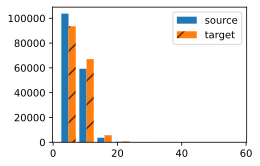

In [ ]:
d2l.set_figsize()
_, _, patches = d2l.plt.hist([[len(l)
                               for l in source], [len(l) for l in target]],
                             label=['source', 'target'])
for patch in patches[1].patches:
    patch.set_hatch('/')
d2l.plt.legend(loc='upper right');

Most of the text sequences have fewer than 20 tokens

# Vocabulary

Since the machine translation dataset consists of pairs of languages, we can build two vocabularies for both the source language and the target language separately. With word-level tokenization, the vocabulary size will be significantly larger than that using character-level tokenization. To alleviate this, here we treat infrequent tokens that **appear less than 2 times as the same unknown $(“<unk>”)$ token**. Besides that, we specify additional special tokens such as for padding $(“<pad>”)$ sequences to the same length in minibatches, and for marking the beginning $(“<bos>”)$ or end $(“<eos>”)$ of sequences. Such special tokens are commonly used in natural language processing tasks.



In [ ]:
src_vocab = d2l.Vocab(tokens=source, min_freq=2, reserved_tokens=['<pad>','<bos>','<eos>'])
len(src_vocab)

10012

In [ ]:
print(src_vocab['hello'])
print(src_vocab.idx_to_token[1807])
print(src_vocab['<unk>'])
print(src_vocab['<pad>'])
print(src_vocab['<bos>'])
print(src_vocab['<eos>'])

1807
hello
0
1
2
3


# Reading the dataset

## Truncate and Padding

For computational efficiency, we can still process a minibatch of text sequences at one time by truncation and padding. Suppose that every sequence in the same minibatch should have the same length **num_steps**. If a text sequence has fewer than **num_steps** tokens, we will keep appending the special $“<pad>”$ token to its end until its length reaches **num_steps**. Otherwise, we will **truncate** the text sequence **by only taking its first num_steps tokens** and **discarding the remaining**. In this way, every text sequence will have the same length to be loaded in minibatches of the same shape.

In [ ]:
def truncate_pad(line, num_steps, padding_token):
  # line: list of strings
  # num_steps: sequence length

  if len(line) > num_steps:
    return line[:num_steps] # Truncate
  
  return line + [padding_token] * (num_steps - len(line))  # Pad

In [ ]:
line = src_vocab[source[0]]
print(line)
print(truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>']))

[47, 4]
[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]


Transform text sequences into minibatches for training

In [ ]:
def build_array_nmt(lines, vocab, num_steps):
  lines = [vocab[l] for l in lines]
  lines = [l + [vocab['<eos>']] for l in lines]
  array = torch.tensor([
              truncate_pad(l, num_steps, vocab['<pad>']) for l in lines
  ])
  valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
  return array, valid_len

# Putting all things together

In [ ]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
  """Return the iterator and the vocabularies of the translation dataset."""
  text = preprocess_nmt(read_data_nmt())
  source, target = tokenize_nmt(text, num_examples)
  src_vocab = d2l.Vocab(source, min_freq=2,
                        reserved_tokens=['<pad>', '<bos>', '<eos>'])
  tgt_vocab = d2l.Vocab(target, min_freq=2,
                        reserved_tokens=['<pad>', '<bos>', '<eos>'])
  src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
  tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
  data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
  data_iter = d2l.load_array(data_arrays, batch_size)
  return data_iter, src_vocab, tgt_vocab

In [ ]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
  print('X:', X.type(torch.int32), X.shape)
  print('valid lengths for X:', X_valid_len)
  print('Y:', Y.type(torch.int32), Y.shape)
  print('valid lengths for Y:', Y_valid_len)
  break

X: tensor([[52, 75,  4,  3,  1,  1,  1,  1],
        [44, 56,  5,  3,  1,  1,  1,  1]], dtype=torch.int32) torch.Size([2, 8])
valid lengths for X: tensor([4, 4])
Y: tensor([[ 30, 113,  22,   5,   3,   1,   1,   1],
        [151,  15,  29,  74,   5,   3,   1,   1]], dtype=torch.int32) torch.Size([2, 8])
valid lengths for Y: tensor([5, 6])


# Summary

- Machine translation refers to the automatic translation of a sequence from one language to another.

- Using word-level tokenization, the vocabulary size will be significantly larger than that using character-level tokenization. To alleviate this, we can treat infrequent tokens as the same unknown token.

- We can truncate and pad text sequences so that all of them will have the same length to be loaded in minibatches.